# Getting LLMs to Perform Regression

This notebook explores the claim that LLMs can perform regression when training data is included as in-context examples - i.e., when labelled feature data is included in the prompt sent to the model. The paper that motivated this work is,

["_From Words to Numbers: You LLM is Secretly a Capable Regressor_", by Vacareanu et al. (2024)](https://arxiv.org/abs/2404.07544).

We've focused exclusively on OpenAI LLMs (accessed via API), and wrapped all of the code into single class, `OpenAiRegressor`. This implements the Scikit-Learn [BaseEstimator](https://arxiv.org/abs/2404.07544) interface - i.e., the class has `fit` and `predict` methods with the same signature as those found in Scikit-Learn models. You can find the source code in `src/llm_regression/models.py` and/or install the package and import it directly, as we've done below.

## Configuring OpenAI API Keys

If you want to try this code for yourself, then you'll need an OpenAI API key. Can be set as an environment variable - e.g.,

```python
import os

os.environ["OPEN_API_KEY"] = "your-open-api-key"
```

Alternatively, you can add the environment variable to a `.env` file in your working directory and `OpenAiRegressor` will pick it up for there (make sure to keep this file out of source control),

```
touch .env
"OPEN_API_KEY=your-open-api-key" >> .env
```

## How do we get LLMs to Perform Regression?

By sending them prompts that includes labelled feature data and then asking the model to provide a missing input - e.g.,

```text
Your task is to provide your best estimate for ”Output”. Please provide that
and only that, without any additional text.

Feature 0: -0.8333688059494058
Output: -0.6929185295193974

Feature 0: -0.3356073681186462
Output: -0.24922638778859663

...

Feature 0: 0.5336073681182466
Output:
```

This prompt format is taken directly from Vacareanu et al's paper.

## Imports & Configuration

If you've cloned this repo you install the required dependencies using,

```text
pip install ".[examples]"
```

Alternatively, you can install everything you need directly from GitHub,

```text
pip install "llm_regression[examples] @ git+https://github.com/AlexIoannides/llm-regression.git"
```

In [1]:
import pandas as pd
import seaborn as sns
from llm_regression import OpenAiRegressor, make_univariate_linear_test_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

sns.set_theme()

## Make Regression Data

To keep this example simple we're going to generate univariate regression data by sampling from the following model,

$
\tilde{y} = \rho \cdot \tilde{x} + \sqrt{1 - \rho^2} * \tilde{\epsilon}
$

Where both $\tilde{y}$ and $\tilde{\epsilon}$ are drawn from the standardised Normal distribution. This model has the property that $\rho$ determines the correlation between $\tilde{y}$ and $\tilde{\epsilon}$, and that the variance of $\tilde{y}$ will also be 1 (like that for $\tilde{x}$).

We will restrict ourselves to 500 samples so that we don't breach GPT-3.5-Turbo's context window of 16k tokens.

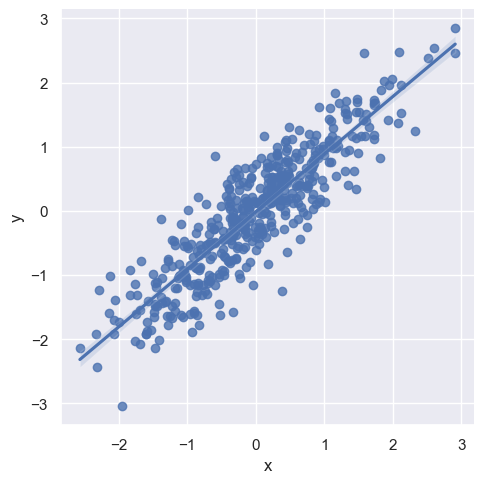

In [2]:
n_samples = 500
dataset = make_univariate_linear_test_data(n_samples, rho=0.9)
train_data, test_data = train_test_split(dataset, test_size=0.05, random_state=42)

_ = sns.lmplot(train_data, x="x", y="y")

## Establish Baseline Results with OLS Regression

We need something 'sensible' to compare the LLM regressor to. We use Scikit-Learn's `LinearRegression` class - a reference implementation of Ordinary Least Squares (OLS) regression.

In [3]:
ols_regressor = LinearRegression()
ols_regressor.fit(train_data[["x"]], train_data[["y"]])
y_pred_ols = ols_regressor.predict(test_data[["x"]])

ols_results = (
    test_data.copy()
    .reset_index(drop=True)
    .assign(y_pred=y_pred_ols)
)

mean_abs_err_ols = mean_absolute_error(ols_results["y"], ols_results["y_pred"])
r_squared_ols = r2_score(ols_results["y"], ols_results["y_pred"])

print(f"mean_abs_error = {mean_abs_err_ols:.3f}")
print(f"r_squared = {r_squared_ols:.3f}")

mean_abs_error = 0.338
r_squared = 0.819


## Results using GPT-3.5-Turbo

A reassuringly expensive (and slow) regression...

In [4]:
gpt35_regressor = OpenAiRegressor(model="gpt-3.5-turbo")
gpt35_regressor.fit(train_data[["x"]], train_data[["y"]])  # -> add in-context examples to prompt
y_pred_gpt35 = gpt35_regressor.predict(test_data[["x"]])

gpt35_results = (
    test_data.copy()
    .assign(y_pred=y_pred_gpt35)
    .reset_index(drop=True)
)

mean_abs_err_gpt35 = mean_absolute_error(gpt35_results["y"], gpt35_results["y_pred"])
r_squared_gpt35 = r2_score(gpt35_results["y"], gpt35_results["y_pred"])

print(f"mean_abs_error = {mean_abs_err_gpt35}")
print(f"r_squared = {r_squared_gpt35}")

100%|██████████| 25/25 [02:24<00:00,  5.78s/it]

mean_abs_error = 0.36279553096328465
r_squared = 0.7855017401502886


Comparable with OLS regression!

## Results using GPT-4o

Like wheeling out a Ferrari to pop to the shops in heavy traffic...

In [5]:
gpt4o_regressor = OpenAiRegressor(model="gpt-4o")
gpt4o_regressor.fit(train_data[["x"]], train_data[["y"]])  # -> add in-context examples to prompt
y_pred_gpt4o = gpt4o_regressor.predict(test_data[["x"]])

gpt4o_results = (
    test_data.copy()
    .assign(y_pred=y_pred_gpt4o)
    .reset_index(drop=True)
)

mean_abs_err_gpt4o = mean_absolute_error(gpt4o_results["y"], gpt4o_results["y_pred"])
r_squared_gpt4o = r2_score(gpt4o_results["y"], gpt4o_results["y_pred"])

print(f"mean_abs_error = {mean_abs_err_gpt4o}")
print(f"r_squared = {r_squared_gpt4o}")

100%|██████████| 25/25 [05:18<00:00, 12.73s/it]

mean_abs_error = 0.3408701555030433
r_squared = 0.8003145027275651


Even better, although I'm not sure it was worth the extra £ or time (or environmental impact...). If we were exploiting the larger context windown that comes with GPT-4o, then maybe we could justify using it.

## Comparing Results

Let's take a look at 'predicted vs. actual' for OLS regression and GPT-4o (to make sure there's nothing odd going on).

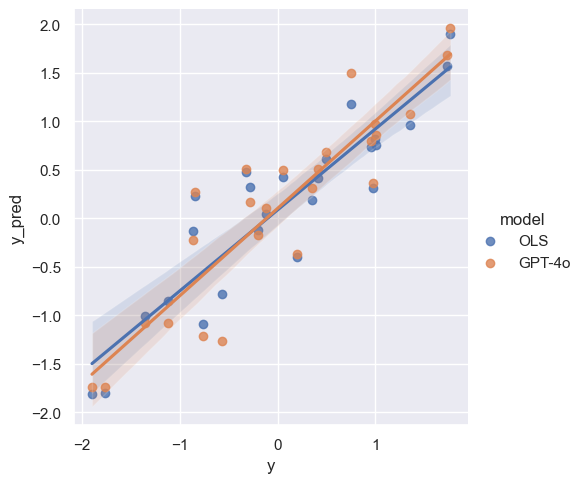

In [6]:
combined_results = pd.concat(
    [ols_results.assign(model="OLS"), gpt4o_results.assign(model="GPT-4o")]
)

_ = sns.lmplot(combined_results, x="y", y="y_pred", hue="model")

The two models produce comparable results, with GPT-4o 'a bit off' on a couple of predictions, which is probably what is driving the difference in performance metrics.